<h1 style="font-size:30px;">Using the Sequence Class in TensorFlow to Build a Data Pipeline</h1>

In the previous notebook, you learned how to use `tf.data` to create datasets for training. We saw how to load datasets from disk as well as from memory. However, there may be times when we need to write our own custom classes to prepare a dataset for training. The `Sequence` class in TensorFow can be used as a base object for implementing a custom data loader class.

But why use the `tf.keras.utils.Sequence` module to create datasets when we already have the convenience of `image_dataset_from_directory` and `tf.data.Dataset`?

Let's summarize the important reasons:

1. A custom data loader class provides flexibility while preparing the data. We can create batches of data from complex and unordered directories, CSV files, and multiple folders containing images. We have complete control over how the image and label data is read and processed since we implement the class ourselves.
2. The directory structure might not be in a format that `image_dataset_from_directory` expects. 

3. We may also want to use different image resolutions for each batch. Using a custom data load class will enable us to handle this programmatically.
4. Using the `Sequence` class, we can apply different image augmentations to each batch if desired.
5. And finally, using data batches generated from the `Sequence` class gives us the opportunity to use two optional arguments in the `fit()` method that can reduce the time required to train the model.

    * `workers`: Integer that specifies the number of processes to use when using process-based threading.
    * `use_multiprocessing`: Boolean value. If `True`, it enables process-based threading.
    
    Generally, when we use these two options with data batches from the `Sequence` class, we can reduce the time required to train the model.


## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Prepare the Data](#2-Download-and-Prepare-the-Data)
* [3 Training and Dataset Configurations](#3-Training-and-Dataset-Configurations)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 Create a CustomDataLoader Class](#5-Create-a-CustomDataLoader-Class)
* [6 Create the Datasets](#6-Create-the-Datasets)
* [7 Compile and Train the Model](#7-Compile-and-Train-the-Model)
* [8 Plot the Training Results](#8-Plot-the-Training-Results)
* [9 Conclusion](#9-Conclusion)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os

import cv2
import glob as glob
import math
import requests
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Flatten, Dense)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False

## 1 System Configuration

In [ ]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[]
Using CPU


## 2 Download and Prepare the Data

We will use the CIFAR10 dataset just like the previous notebook. Using the same dataset will help to clarify the concepts of different custom data loading techniques. This CIFAR10 dataset has been downloaded from <a href="https://pjreddie.com/projects/cifar-10-dataset-mirror/" target=_blank>Joseph Redmon's website</a> and modified such that all the images are in their respective class folders.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/6jrhe7uu4a4qxbn/cifar10.zip?dl=1',
    'cifar10.zip'
)
    
unzip(zip_file='cifar10.zip')

Extracted all


```
cifar10
├── labels.txt
├── test
│   ├── airplane
│   ├── automobile
│   ├── bird
│   ├── cat
│   ├── deer
│   ├── dog
│   ├── frog
│   ├── horse
│   ├── ship
│   └── truck
└── train
    ├── airplane
    ├── automobile
    ├── bird
    ├── cat
    ├── deer
    ├── dog
    ├── frog
    ├── horse
    ├── ship
    └── truck
```

As you can see, we have `train` and `test` subdirectories which in turn contain sub-directories for each class in the CIFAR10 dataset. All the class folders contain the respective images.

## 3 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 16
    EPOCHS:        int = 11
    LEARNING_RATE: float = 0.0005


@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:   int = 10
    IMG_HEIGHT:    int = 32
    IMG_WIDTH:     int = 32
    DATA_TRAIN_IMAGES: str = './cifar10/train/*/*.png'
    DATA_VALID_IMAGES: str = './cifar10/test/*/*.png'

## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)
    
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_model_summary:
        model.summary()
        
    return model

In [ ]:
model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES, 
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                            

2022-07-25 17:12:55.374993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 5 Create a `CustomDataLoader` Class
Here, we will write our custom class using the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence" target=_blank>**`tf.keras.utils.Sequence`**</a> class. In the code cell below, we define the `CustomDataLoader` class, which is a subclass of the `Sequence` class. In defining this custom class, we are going to override three of the so-called "dunder" (for double underscore) methods for our own purposes:

* `__init__()`
* `__len__()`
* `__getitem__()`

In the section that follows, we will review each of these methods and their purpose. There is another method known as `on_epoch_end` that we have not implemented here. It is not mandatory, but if you want some operations to take place at the end of each epoch, you can implement it.

In [ ]:
class CustomDataLoader(Sequence):

    def __init__(self, batch_size, image_size, image_paths):

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths

        # List containing all the labels in the dataset.
        self.labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        self.num_classes = len(self.labels)

        # Create the list of class names for the dataset.
        self.class_names = [self.image_paths[i].split(os.path.sep)[-2] for i in range(len(self.image_paths))]

        # Map the class names to the labels and prepare the final list.
        self.all_labels = [self.labels.index(x) for x in self.class_names]

        # Shuffle the image path list and labels list in the same order.
        joined_lists = list(zip(self.image_paths, self.all_labels))

        # Shuffle the joined lists.
        random.shuffle(joined_lists)

        # Get the lists separately again.
        self.all_images, self.all_labels = zip(*joined_lists)

        # Convert labels to one-hot encoding.
        self.all_labels = to_categorical(self.all_labels, self.num_classes)

        # Create placeholders for image and label data.
        self.image = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.label = np.empty((self.batch_size,) + (self.num_classes,), dtype="float32")

    def __len__(self):

        # Return the number of data batches.
        return math.ceil(len(self.all_images) / self.batch_size)

    def __getitem__(self, idx):
        
        # Create image batch file names for the current batch.
        batch_image_paths = self.all_images[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.all_labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        # Read image data, convert to RGB and resize.
        for j, file_name in enumerate(batch_image_paths):
            
            # Read image file,convert to RGB, and resize.
            self.image[j] = cv2.resize(cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB), self.image_size)
                
            # Create label batch for the current batch.
            self.label[j] = batch_labels[j]
                
        return self.image, self.label

### `__init__()`
In the `__init__()` method, we initialize all the variables we need in the entire class for preparing the dataset.
We also create placeholders (`self.image` and `self.label`) for the image and label data returned by the `_getitem_()` method.

Also, note that we are shuffling the image paths and labels in the same order. We should always shuffle the data before training to minimize any bias that may be introduced by the way the data was originally ordered.
    
### `__len__()`
The  `__len__()` method returns the number of data batches (number of data samples divided by the batch size). This allows us to enumerate through all the data batches based on the length of the object. 


### `__getitem__()`

The `__getitem__()` method allows instances of a class to use the indexer operator `[]`, so if you have an instance of a class, say `obj`, then when you evaluate `obj[idx]` python calls `obj.__getitem__(idx)`. As we enumerate through items in the object, the value of `idx` is incremented, and we use it along with the batch size (`self.batch_size`) to extract the `batch_image_paths` from `self.all_images` and use that list to read and resize the images for the current batch. We also retrieve the corresponding one-hot encoded labels in the same manner.

### 5.1 Test the `CustomDataLoader` Class

Before we proceed further, let's use this class to create a sample CustomDataLoader object and experiment with it to better understand how it works.

In [ ]:
train_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))

# Create a sample dataset from the training data.
sample_ds = CustomDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                             image_paths=train_images,
                            )

# Retrieve the images and the labels for the fourth batch of data.
image_batch = sample_ds[3][0]  
label_batch = sample_ds[3][1]  

# Print the first three one-hot labels from the fourth batch of data.
print(label_batch[0:3])
print('\n')

# This is equivalent to the code above. 
# sample_ds[] is implemented as: sample_ds.__getitem__()
image_batch, label_batch = sample_ds.__getitem__(3)
print(label_batch[0:3])
print('\n')

# Print the length of the object.
print(f"Number of batches: {len(sample_ds)}")

# len(sample_ds) is implemented as: sample_ds.__len__()
print(f"Number of batches: {sample_ds.__len__()}\n")

print("image shape: ", image_batch.shape)
print("label shape: ", label_batch.shape)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


Number of batches: 625
Number of batches: 625

image shape:  (16, 32, 32, 3)
label shape:  (16, 10)


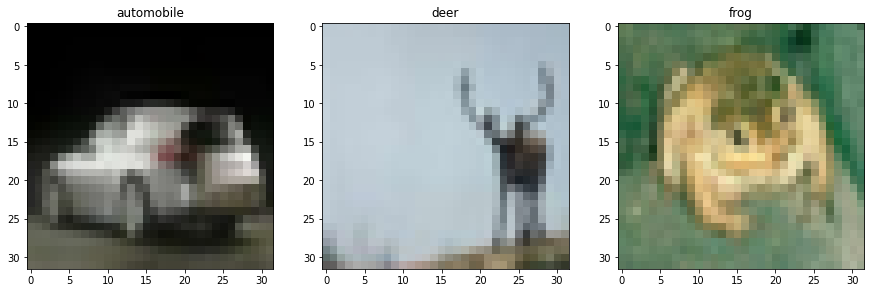

In [ ]:
plt.figure(figsize=(15, 5));

# Let's enumerate through a few data batches.
for i, (image_batch, label_batch) in enumerate(sample_ds):

    if i == 3:
        # Break after three batches.
        break

    # Display the first image from each batch.
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.array(image_batch[0]) / 255.)
    plt.title(sample_ds.labels[np.argmax(label_batch[0])]);

## 6 Create the Datasets

In [ ]:
train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))

train_ds = CustomDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                            image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                            image_paths=train_images,
                            )

valid_ds = CustomDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                            image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                            image_paths=valid_images,
                            )

## 7 Compile and Train the Model 

## 7.1 `model.fit()` Input Arguments

It's worth emphasizing here that the fit method in Keras can accept a wide range of inputs representing the input data. Earlier in the course, we specified the input training data as separate NumPy arrays for the images (`X_train`) and labels (`y_train`). Then when we starting using `image_dataset_from_directory()` and `tf.data.Dataset`, we created dataset objects that contained both the images and the labels. Now we have an object based on keras.utils.Sequence returns a tuple of inputs and targets `(images, labels)`, which can also be specified as the input to the `model.fit()` method in Keras. Referring to the documentation <a href="https://github.com/keras-team/keras/blob/v2.9.0/keras/engine/training.py#L1099-L1472" target=_blank>model.fit</a>, notice when `x` is a dataset, generator, or `keras.utils.Sequence` instance, `y` should not be specified (since targets will be obtained from `x`). Similarly, for the validation data, when the input takes the form on NumPy Arrays, we supply those as a tuple (`X_train`, `y_train`), or when the validation data is represented as either a dataset or a sequence we simply specify the object which contains both the images and the labels. 

## 7.2 `model.fit()` Performance Arguments

As we mentioned earlier, when the dataset is represented as a `Sequence`, we can use the optional arguments, `workers` and `use_multiprocessing` to reduce the time required to train the model. Note, if you execute this notebook on your local system, these arguments may cause your code to crash, so if you encounter this, you can remove those inputs, or execute the notebook on Google Colab.

In [ ]:
# Compile the model and train it.
model.compile(optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
             )

history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    validation_data=valid_ds,
#                     workers=4,
#                     use_multiprocessing=True,
                   )

Epoch 1/11
3125/3125 [==============================] - 19s 6ms/step - loss: 2.1521 - accuracy: 0.2312 - val_loss: 1.8126 - val_accuracy: 0.3173
Epoch 2/11
3125/3125 [==============================] - 19s 6ms/step - loss: 1.7453 - accuracy: 0.3535 - val_loss: 1.7719 - val_accuracy: 0.3550
Epoch 3/11
3125/3125 [==============================] - 21s 7ms/step - loss: 1.6382 - accuracy: 0.3984 - val_loss: 1.6006 - val_accuracy: 0.4124
Epoch 4/11
3125/3125 [==============================] - 23s 7ms/step - loss: 1.5279 - accuracy: 0.4451 - val_loss: 1.5930 - val_accuracy: 0.4245
Epoch 5/11
3125/3125 [==============================] - 26s 8ms/step - loss: 1.4324 - accuracy: 0.4852 - val_loss: 1.4696 - val_accuracy: 0.4699
Epoch 6/11
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3429 - accuracy: 0.5175 - val_loss: 1.4055 - val_accuracy: 0.4971
Epoch 7/11
3125/3125 [==============================] - 38s 12ms/step - loss: 1.2714 - accuracy: 0.5470 - val_loss: 1.3477 - val_

## 8 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

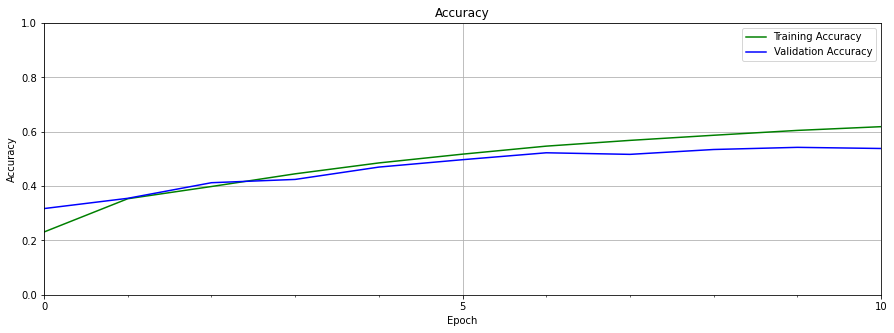

In [ ]:
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

## 9 Conclusion
In this notebook, we learned how to use the `Sequence` class to create a `CustomDataLoader` class for a classification dataset. We saw how to prepare the CIFAR10 dataset when the images are inside directories residing on the the file system. In the next notebook, we will learn about another approach which uses a format called `TFRecords` which allows you to store and access data that is especially helpful when working with large datasets used by deep learning systems.